## Problem statement

For a financial company, customer complaints carry a lot of importance, as they are often an indicator of the shortcomings in their products and services. If these complaints are resolved efficiently in time, they can bring down customer dissatisfaction to a minimum and retain them with stronger loyalty. This also gives them an idea of how to continuously improve their services to attract more customers.



These customer complaints are unstructured text data; so, traditionally, companies need to allocate the task of evaluating and assigning each ticket to the relevant department to multiple support employees. This becomes tedious as the company grows and has a large customer base.



In this case study, you will be working as an NLP engineer for a financial company that wants to automate its customer support tickets system. As a financial company, the firm has many products and services such as credit cards, banking and mortgages/loans.

## Business goal
You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.



With the help of non-negative matrix factorization (NMF), an approach under topic modelling, you will detect patterns and recurring words present in each ticket. This can be then used to understand the important features for each cluster of categories. By segregating the clusters, you will be able to identify the topics of the customer complaints.

## Index

1. Importing the necessary libraries and Dataset

2. Data Preparation

3. Text Pre-Processing

4. Exploratory Data Analysis

5. Feature Extraction

6. Topic Modelling using NMF

7. Supervised model for Prediction of New Complaint

## 1. Importing the necessary libraries and Dataset

In [3]:
# importing required libraries

import json
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from textblob import TextBlob
from collections import Counter
from scipy import stats
from wordcloud import WordCloud, STOPWORDS

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint

from gensim.corpora.dictionary import Dictionary
from gensim.models.nmf import Nmf
from gensim.models.coherencemodel import CoherenceModel
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

# importing warnings
import warnings
warnings.filterwarnings("ignore")

# displaying maximum columns
pd.options.display.max_columns = None

In [4]:
# Opening JSON file
file_name = open('complaints-2021-05-14_08_16.json')

# returns JSON object as a dictionary
data = json.load(file_name)
df=pd.json_normalize(data)

# taking look at random samples
df.sample(5)

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,_source.consumer_disputed,_source.product,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
12959,complaint-public-v2,complaint,440292,0.0,None,891XX,440292,"Loan servicing, payments, escrow account",2013-06-24T12:00:00-05:00,NV,No,Mortgage,Closed with explanation,JPMORGAN CHASE & CO.,Web,2013-06-26T12:00:00-05:00,None,Conventional adjustable mortgage (ARM),Yes,,None,N/A
77488,complaint-public-v2,complaint,925628,0.0,None,43081,925628,"Application, originator, mortgage broker",2014-07-07T12:00:00-05:00,OH,No,Mortgage,Closed with non-monetary relief,JPMORGAN CHASE & CO.,Referral,2014-07-10T12:00:00-05:00,None,Other mortgage,Yes,,None,N/A
27513,complaint-public-v2,complaint,683295,0.0,None,60619,683295,"Account opening, closing, or management",2014-01-23T12:00:00-05:00,IL,Yes,Bank account or service,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2014-02-03T12:00:00-05:00,None,Other bank product/service,Yes,,None,N/A
19111,complaint-public-v2,complaint,3736010,0.0,None,None,3736010,Attempts to collect debt not owed,2020-07-08T12:00:00-05:00,LA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2020-07-08T12:00:00-05:00,None,Credit card debt,Yes,These accounts are an result of fraud JPMCB {$...,Debt was result of identity theft,Consent provided
22566,complaint-public-v2,complaint,3201113,0.0,None,840XX,3201113,Trouble during payment process,2019-04-04T12:00:00-05:00,UT,N/A,Mortgage,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-04T12:00:00-05:00,None,Conventional home mortgage,Yes,On XX/XX/XXXX My father XXXX XXXX XXXX and I s...,None,Consent provided


## 2. Data preparation

In [5]:
# Inspect the dataframe to understand the given data.
df.shape

(78313, 22)

In [6]:
#print the column names
df.columns

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')

In [7]:
#Assign new column names
df = df.rename(columns= {
    '_index': 'index', '_type': 'type', '_id' : 'id', '_score' : 'score', '_source.tags' : 'tags',
    '_source.zip_code' : 'zip_code', '_source.complaint_id': 'complaint_id', '_source.issue' : 'issue',
    '_source.date_received': 'date_received', '_source.state' : 'state', '_source.consumer_disputed' :'consumer_disputed',
    '_source.product' : 'product', '_source.company_response' : 'company_response', '_source.company' : 'company',
    '_source.submitted_via' : 'submitted_via', '_source.date_sent_to_company' : 'date_sent_to_company',
    '_source.company_public_response' : 'company_public_response', '_source.sub_product' : 'sub_product',
    '_source.timely' : 'timely', '_source.complaint_what_happened' : 'complaint_what_happened', '_source.sub_issue' : 'sub_issue',
    '_source.consumer_consent_provided' : 'consumer_consent_provided'
})

# cross check
df.sample()

,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,consumer_disputed,product,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided
20983,complaint-public-v2,complaint,1906381,0.0,None,55016,1906381,Identity theft / Fraud / Embezzlement,2016-05-03T12:00:00-05:00,MN,No,Credit card,Closed with explanation,JPMORGAN CHASE & CO.,Web,2016-05-03T12:00:00-05:00,None,None,Yes,,None,Consent not provided


In [8]:
# checking null values in all columns
df.isnull().sum()

index                            0
type                             0
id                               0
score                            0
tags                         67413
zip_code                      6757
complaint_id                     0
issue                            0
date_received                    0
state                         1991
consumer_disputed                0
product                          0
company_response                 0
company                          0
submitted_via                    0
date_sent_to_company             0
company_public_response      78309
sub_product                  10571
timely                           0
complaint_what_happened          0
sub_issue                    46297
consumer_consent_provided     1008
dtype: int64

`complaint_what_happened` column contain bank observations, to remove them need to conver it into NaN values

In [9]:
# Assign nan in place of blanks in the complaint_what_happened column
df['complaint_what_happened'] = df['complaint_what_happened'].replace(r'', np.NaN)

In [10]:
# now checking the null values again
df['complaint_what_happened'].isnull().sum()

57241

In [11]:
#Remove all rows where complaints column is nan

df = df.dropna(subset=["complaint_what_happened"])

In [12]:
# cross check for null values and printing the shape of the dataset
print(df['complaint_what_happened'].isnull().sum())
print(df.shape)

0
(21072, 22)


## 3. Text Pre-Processsing

Includes the following step:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers
* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [13]:
# Creating the function for lower case each word, remove square brackests, punctuations and words contining numbers

def text_cleaning(text):
  # https://regex101.com/
  text = text.lower()
  text = re.sub(r'\[.*?\]', '', text) # removing text in []
  text = re.sub(r'[^\w\s]', '', text) # removing punctuations
  text = re.sub(r'\w*\d\w*', '', text) # removing number
  return text

In [14]:
# applying the above defined function
df['complaint_what_happened'] = df['complaint_what_happened'].apply(text_cleaning)

df.sample()

,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,consumer_disputed,product,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided
61538,complaint-public-v2,complaint,2062281,0.0,None,33130,2062281,Delinquent account,2016-08-13T12:00:00-05:00,FL,No,Credit card,Closed with explanation,JPMORGAN CHASE & CO.,Web,2016-08-13T12:00:00-05:00,None,None,Yes,i am a xxxx and make poor choices i should not...,None,Consent provided


In [15]:
# creating new dataframe for further analysis

data = {'orignal_text' : df['complaint_what_happened']}
new_df = pd.DataFrame(data=data)

new_df.head()

,orignal_text
1,good morning my name is xxxx xxxx and i apprec...
2,i upgraded my xxxx xxxx card in and was told ...
10,chase card was reported on however fraudulent...
11,on while trying to book a xxxx xxxx ticket ...
14,my grand son give me check for i deposit it i...


In [16]:
# defining the function for the lemmatization of the text

def lammetizer(text):
  string = []
  doc = nlp(text)
  for i in doc:
    string.append(i.lemma_)
  return ' '.join(string)

In [17]:
# applying the lemmatization for the cleaned text

new_df['lemmatized_text'] = new_df['orignal_text'].apply(lammetizer)

In [18]:
new_df.head(5)

,orignal_text,lemmatized_text
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...
2,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...
14,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...


In [21]:
# downloading the dependencies
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [22]:
#Write your function to extract the POS tags for noun

def pos_tag(text):
  textblob = TextBlob(text)
  return ' '.join([ word for (word, tag) in textblob.tags if tag == 'NN'])

# applying POS tags
new_df["complaint_POS_removed"] =  new_df['lemmatized_text'].apply(pos_tag)

In [23]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
new_df.head()

,orignal_text,lemmatized_text,complaint_POS_removed
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service ask ...
2,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...,card agent upgrade date agent information orde...
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,card report application identity consent servi...
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,try book xxxx ticket offer ticket card informa...
14,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund bank account pay money ...


## 4. Exploratory Data Analysis





#### A. Visualization of the complaint column based on the length

In [24]:
# Write your code here to visualise the data according to the 'Complaint' character length

doc_len = [len(i) for i in new_df['complaint_POS_removed']]

print('Maximum length of document:', max(doc_len))
print('Minimum length of document:', min(doc_len))

Maximum length of document: 12749
Minimum length of document: 0


In [25]:
# check
[i for i in new_df['complaint_POS_removed'] if len(i) == 0]

['', '', '', '', '', '']

In [26]:
# removing the rows with 0 lengths
new_df = new_df[new_df['complaint_POS_removed'].str.len() > 0]

In [27]:
# Write your code here to visualise the data according to the 'Complaint' character length

doc_len = [len(i) for i in new_df['complaint_POS_removed']]

print('Maximum length of document:', max(doc_len))
print('Minimum length of document:', min(doc_len))

Maximum length of document: 12749
Minimum length of document: 5


In [28]:
# Descriptive statistics of the complaint length column
stats.describe(doc_len)

DescribeResult(nobs=21066, minmax=(5, 12749), mean=423.1058577803095, variance=234571.73424814385, skewness=6.945397795626434, kurtosis=108.35672838044887)

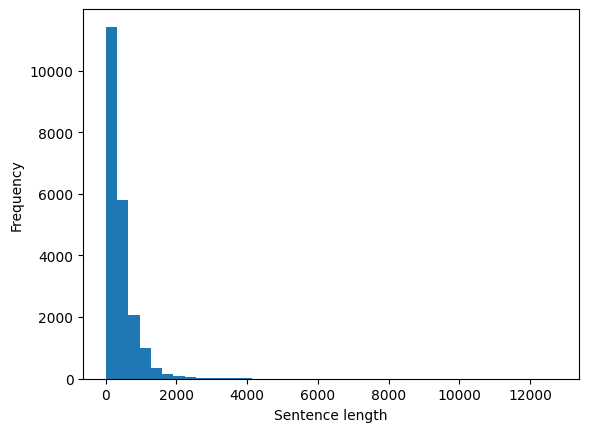

In [29]:
# plotting the histogram

plt.hist(doc_len, bins = 50)
plt.xlabel('Sentence length')
plt.ylabel('Frequency')
plt.show()

- There are total 21066 observations present in the dataset, the length of complaint caries betweeen 5 to 12749 words. With the average sentence length of sentence as 423 words.
- The histogram of sentence length is rightly skewed, shows that majority of complaints are of sorter length.

#### B. Top 40 words by frequency among all the articles.

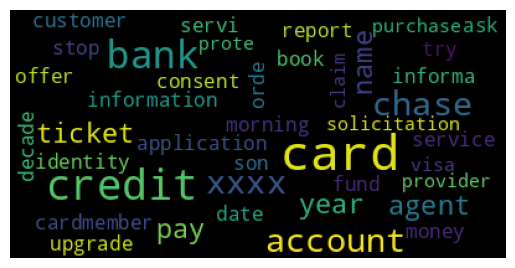

In [30]:
# Using a word cloud top 40 words by frequency among all the articles after processing the text
# taking out the stopwords
stopword = set(STOPWORDS)

wordcloud = WordCloud(
                          background_color='black',
                          stopwords=stopword,
                          max_words=40,
                          max_font_size=40,
                          random_state=100
                         ).generate(str(new_df['complaint_POS_removed']))

# printing the words using wordcloud
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [31]:
# printing top 40 words by frequency by counter method

flattened_list = [word for sublist in new_df['complaint_POS_removed'].apply(nltk.word_tokenize) for word in sublist]

word_freq = Counter(flattened_list)

# Select top 40 words by frequency
top_40_words = word_freq.most_common(40)

print(top_40_words)

[('account', 47514), ('chase', 46698), ('xxxx', 36562), ('credit', 34148), ('card', 29278), ('bank', 28402), ('payment', 21165), ('time', 16021), ('charge', 14996), ('day', 12972), ('xxxxxxxx', 12401), ('check', 12294), ('money', 11961), ('loan', 11000), ('state', 9692), ('letter', 9669), ('information', 9654), ('report', 8971), ('call', 8966), ('transaction', 8650), ('fee', 8634), ('number', 8619), ('month', 8462), ('amount', 8394), ('year', 8292), ('mortgage', 8193), ('customer', 8163), ('claim', 7851), ('balance', 7743), ('phone', 7718), ('service', 7702), ('company', 7626), ('fraud', 7115), ('fund', 6999), ('date', 6413), ('issue', 6180), ('dispute', 5652), ('business', 5590), ('interest', 5334), ('statement', 5268)]


In [32]:
#Removing -PRON- from the text corpus
new_df['Complaint_clean'] = new_df['complaint_POS_removed'].str.replace('-PRON-', '')

#### C. Looking for top 10 unigrams, bigrams and trigrams by frequency among all the complaints

In [33]:
# https://practicaldatascience.co.uk/machine-learning/how-to-use-count-vectorization-for-n-gram-analysis

# Creating the function which will print the unigram, bigram and trigram based on inputs from the given text

def for_n_grams(text, n, ngram_from=2, ngram_to=2, max_features = 20000):
  # count vectorizer with english stopwords, and ngrams
  count_vec = CountVectorizer(stop_words = 'english', ngram_range = (ngram_from, ngram_to))
  # Fitting it on the dataset and transforming it into the dataset
  count_table = count_vec.fit_transform(text).toarray()
  count_df = pd.DataFrame(data = count_table, columns= count_vec.get_feature_names_out())
  # getting total sum of the observation present in the dataset
  sum_df = count_df.sum(axis = 0).sort_values(ascending=False).to_frame().reset_index().head(n)
  sum_df.columns=["nGram", "Frequency"] # renaming the column name
  return sum_df

In [34]:
# Print the top 10 unigram words with frequency

df_top10_unigram = for_n_grams(new_df['complaint_POS_removed'], 10, 1,1)
df_top10_unigram

,nGram,Frequency
0,account,47514
1,chase,46698
2,xxxx,36562
3,credit,34148
4,card,29278
5,bank,28402
6,payment,21165
7,time,16021
8,charge,14996
9,day,12972


In [35]:
# Print the top 10 bigram words with frequency

df_top10_bigram = for_n_grams(new_df['complaint_POS_removed'], 10, 2 ,2)
df_top10_bigram

,nGram,Frequency
0,credit card,12778
1,credit report,3955
2,xxxx xxxx,3953
3,customer service,3081
4,chase credit,2966
5,chase bank,2939
6,bank account,2729
7,account chase,2594
8,chase account,2564
9,check account,2414


In [36]:
# Print the top 10 trigram words with frequency

df_top10_trigram = for_n_grams(new_df['complaint_POS_removed'],30,3,3)
df_top10_trigram

,nGram,Frequency
0,chase credit card,2063
1,credit card account,1022
2,credit card company,991
3,credit card chase,633
4,credit card credit,513
5,inquiry credit report,481
6,charge credit card,422
7,xxxx xxxx xxxx,411
8,account credit card,398
9,card credit card,387


In [37]:
# The personal details of customer has been masked in the dataset with xxxx, removing 'XXXX

new_df['complaint_POS_removed'] = new_df['complaint_POS_removed'].str.replace('xxxx','')

In [38]:
# once again looking for unigram
# check word is newly added

df_top10_unigram = for_n_grams(new_df['complaint_POS_removed'], 10, 1, 1)
df_top10_unigram

,nGram,Frequency
0,account,47516
1,chase,46787
2,credit,34150
3,card,29286
4,bank,28409
5,payment,21167
6,time,16024
7,charge,14996
8,day,12982
9,check,12296


## 5. Feature Extraction using TF-IDF

In [39]:
# TfidfVectorizer

tfidf_vec = TfidfVectorizer(stop_words = 'english',
                            ngram_range= (1,1),
                            max_df = 0.95,
                            min_df = 2,
                            max_features = 20000)

# applying tfidf on data
x = tfidf_vec.fit_transform(new_df['complaint_POS_removed'])

In [40]:
# converting tfidf output into dataset
tdidf_df = pd.DataFrame(data = x.toarray(),
                        columns= tfidf_vec.get_feature_names_out())
tdidf_df.sample(3)

aa  aarp  abandon  abandonment  abatement  abbreviation  abd  abide  \
13269  0.0   0.0      0.0          0.0        0.0           0.0  0.0    0.0   
1040   0.0   0.0      0.0          0.0        0.0           0.0  0.0    0.0   
17819  0.0   0.0      0.0          0.0        0.0           0.0  0.0    0.0   

       ability  abovementione  abovereference  abs  abscond  absence  absent  \
13269      0.0            0.0             0.0  0.0      0.0      0.0     0.0   
1040       0.0            0.0             0.0  0.0      0.0      0.0     0.0   
17819      0.0            0.0             0.0  0.0      0.0      0.0     0.0   

       absolute  absolve  absorb  absurd  absurdity  abundance     abuse  \
13269       0.0      0.0     0.0     0.0        0.0        0.0  0.326409   
1040        0.0      0.0     0.0     0.0        0.0        0.0  0.000000   
17819       0.0      0.0     0.0     0.0        0.0        0.0  0.000000   

       abuser  abusive   ac  acc  acccount  acceleration  accent  accept  \
13269     0.0      0.0  0.0  0.0       0.0           0.0     0.0     0.0   
1040      0.0      0.0  0.0  0.0       0.0           0.0     0.0     0.0   
17819     0.0      0.0  0.0  0.0       0.0           0.0     0.0     0.0   

       acceptance  access  accessibility  accessory  accident  accidental  \
13269         0.0     0.0            0.0        0.0       0.0         0.0   
1040          0.0     0.0            0.0        0.0       0.0         0.0   
17819         0.0     0.0            0.0        0.0       0.0         0.0   

       acco  accommodate  accommodation  accomodation  accompany  accomplice  \
13269   0.0          0.0            0.0           0.0        0.0         0.0   
1040    0.0          0.0            0.0           0.0        0.0         0.0   
17819   0.0          0.0            0.0           0.0        0.0         0.0   

       accomplish  accont  accord  accordance  accorde  accou  accouint  \
13269         0.0     0.0     0.0         0.0      0.0    0.0       0.0   
1040          0.0     0.0     0.0         0.0      0.0    0.0       0.0   
17819         0.0     0.0     0.0         0.0      0.0    0.0       0.0   

       accoun  accound   account  accountability  accountable  accountand  \
13269     0.0      0.0  0.426543             0.0          0.0         0.0   
1040      0.0      0.0  0.059777             0.0          0.0         0.0   
17819     0.0      0.0  0.146942             0.0          0.0         0.0   

       accountant  accountbalance  accountchase  accountholder  accounti  \
13269         0.0             0.0           0.0            0.0       0.0   
1040          0.0             0.0           0.0            0.0       0.0   
17819         0.0             0.0           0.0            0.0       0.0   

       accounting  accountit  accountlevel  accountmy  accounton  accountone  \
13269         0.0        0.0           0.0        0.0        0.0         0.0   
1040          0.0        0.0           0.0        0.0        0.0         0.0   
17819         0.0        0.0           0.0        0.0        0.0         0.0   

       accountrouting  accountschasecom  accountshe  accountthe  accout  \
13269             0.0               0.0         0.0         0.0     0.0   
1040              0.0               0.0         0.0         0.0     0.0   
17819             0.0               0.0         0.0         0.0     0.0   

       accredit  accrue  acct  accumulate  accumulation  accunt  accuracy  \
13269       0.0     0.0   0.0         0.0           0.0     0.0       0.0   
1040        0.0     0.0   0.0         0.0           0.0     0.0       0.0   
17819       0.0     0.0   0.0         0.0           0.0     0.0       0.0   

       accurate  accurateness  accusation  accuse  ach  acion  acivity  ack  \
13269       0.0           0.0         0.0     0.0  0.0    0.0      0.0  0.0   
1040        0.0           0.0         0.0     0.0  0.0    0.0      0.0  0.0   
17819       0.0           0.0         0.0     0

## 6. Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In [41]:
# Tokenize the complaint texts
tokenized_texts = [text.split() for text in new_df['complaint_POS_removed']]

# Create a dictionary
dictionary = Dictionary(tokenized_texts)

# Create the bag-of-words format
corpus = [dictionary.doc2bow(text) for text in tokenized_texts]

In [42]:
# Create a list of the topic numbers we want to try
topic_nums = list(np.arange(3, 10, 1))

In [43]:
# Run the NMF model and calculate the coherence score
coherence_scores = []

for num in topic_nums:
    nmf = Nmf(
        corpus=corpus,
        num_topics=num,
        id2word=dictionary,
        chunksize=2000,
        random_state=40
    )

    # coherence model for score
    cm = CoherenceModel(
        model=nmf,
        texts=tokenized_texts,
        dictionary=dictionary,
        coherence='c_v'
    )

    # appending chherence score to the list
    coherence_scores.append(round(cm.get_coherence(), 5))

In [44]:
# Printing coherence scores for different numbers of topics
for num, score in zip(topic_nums, coherence_scores):
    print(f"Number of topics: {num}, Coherence Score: {score}")

Number of topics: 3, Coherence Score: 0.39894
Number of topics: 4, Coherence Score: 0.36423
Number of topics: 5, Coherence Score: 0.40516
Number of topics: 6, Coherence Score: 0.41927
Number of topics: 7, Coherence Score: 0.41849
Number of topics: 8, Coherence Score: 0.40313
Number of topics: 9, Coherence Score: 0.41428


- When we seelecting 6 as optimum topics then we are getting the optimum coherence score as 0.41927.

#### Final model

In [45]:
# Creating the final model based on optimum parameter

nmf_model = NMF(n_components=6,random_state=40)

# model fitting on the dataset
nmf_model.fit(x)
len(tfidf_vec.get_feature_names_out())

7262

In [46]:
#  Printing Top15 words for each topics

for index, topic in enumerate(nmf_model.components_):
    print(f'THE TOP 15 WORDS FOR TOPIC #{index}')
    print([tfidf_vec.get_feature_names_out()[i] for i in topic.argsort()[-15:]])

THE TOP 15 WORDS FOR TOPIC #0
['customer', 'transfer', 'claim', 'business', 'transaction', 'number', 'day', 'branch', 'deposit', 'chase', 'fund', 'money', 'bank', 'check', 'account']
THE TOP 15 WORDS FOR TOPIC #1
['application', 'service', 'month', 'time', 'purchase', 'offer', 'score', 'point', 'limit', 'year', 'balance', 'account', 'chase', 'credit', 'card']
THE TOP 15 WORDS FOR TOPIC #2
['year', 'chase', 'report', 'account', 'pay', 'date', 'credit', 'auto', 'time', 'day', 'statement', 'fee', 'month', 'balance', 'payment']
THE TOP 15 WORDS FOR TOPIC #3
['time', 'day', 'statement', 'company', 'refund', 'service', 'purchase', 'fraud', 'claim', 'chase', 'merchant', 'dispute', 'transaction', 'fee', 'charge']
THE TOP 15 WORDS FOR TOPIC #4
['sale', 'foreclosure', 'bank', 'house', 'document', 'time', 'letter', 'rate', 'year', 'property', 'modification', 'chase', 'home', 'mortgage', 'loan']
THE TOP 15 WORDS FOR TOPIC #5
['bureau', 'inquire', 'date', 'bureaus', 'theft', 'account', 'score', 'id

In [47]:
 # Creating the best topic for each complaint in terms of integer

topic_results = nmf_model.transform(x)
topic_results[0].round(2)
topic_results[0].argmax()

#Assign the best topic to each of the cmplaints in Topic Column
new_df['Topic'] = topic_results.argmax(axis=1)

In [48]:
new_df.head()

,orignal_text,lemmatized_text,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service ask ...,morning name stop bank cardmember service ask ...,0
2,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...,card agent upgrade date agent information orde...,card agent upgrade date agent information orde...,1
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,card report application identity consent servi...,card report application identity consent servi...,5
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,try book ticket offer ticket card information...,try book xxxx ticket offer ticket card informa...,1
14,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund bank account pay money ...,son chase account fund bank account pay money ...,0


In [49]:
#Creating the dictionary of Topic names and Topics

Topic_names = {0:"Bank Account services",
               1:"Credit card or prepaid card",
               2:"Others",
               3:"Fraud Transactions",
               4:"Mortgage/Loan",
               5:"Theft/Dispute Reporting"}

#Replace Topics with Topic Names
new_df['Topic'] = new_df['Topic'].map(Topic_names)

In [69]:
# looking at the distribution of the topics in dataset
new_df['Topic'].value_counts(normalize= True)*100

0    24.314061
1    20.601918
4    18.176208
3    17.843919
2    11.183898
5     7.879996
Name: Topic, dtype: float64

In [50]:
new_df.sample(2)

,orignal_text,lemmatized_text,complaint_POS_removed,Complaint_clean,Topic
43915,i was charged interest of because i entered t...,I be charge interest of because I enter the ...,interest amount pay bill balance interest bala...,interest amount pay bill balance interest bala...,Credit card or prepaid card
57521,i had a credit card with chase bank a few year...,I have a credit card with chase bank a few yea...,credit card bank year credit limit balance tim...,credit card bank year credit limit balance tim...,Credit card or prepaid card


## 7. Supervised model for Prediction on New Complaint


In [51]:
#Create the dictionary again of Topic names and Topics

Topic_names = {"Bank Account services": 0 ,
               "Credit card or prepaid card" : 1,
               "Others" :2 ,
               "Fraud Transactions": 3,
               "Mortgage/Loan":4,
               "Theft/Dispute Reporting":5}

#Replace Topics with Topic Names
new_df['Topic'] = new_df['Topic'].map(Topic_names)

In [52]:
new_df.sample()


,orignal_text,lemmatized_text,complaint_POS_removed,Complaint_clean,Topic
70201,i called jp morgan chase to find out the statu...,I call jp morgan chase to find out the status ...,chase status account debt representative tell ...,chase status account debt representative tell ...,2


In [53]:
# creating training dataset
training_data= new_df[['orignal_text', 'Topic']]

#### Text Preprocessing

For developing the ML model we need to convert the text into numerical form using CountVectorizer and tfidf

In [54]:
# perfroming the CountVectorizer on orignal text
count_vec = CountVectorizer()
count_vec_train = count_vec.fit_transform(new_df['orignal_text'])

# Transform the word vector to tf-idf
tfidf_vec = TfidfTransformer()
tfidf_vec_train = tfidf_vec.fit_transform(count_vec_train)

In [55]:
# Splitting the data into train test split
x_train, x_test, y_train, y_test =  train_test_split(tfidf_vec_train, training_data.Topic, test_size = 0.25, random_state = 100, shuffle=True)

In [56]:
# Shape
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((15799, 33664), (5267, 33664), (15799,), (5267,))

## Naive Byes

In [57]:
# implementing Naive Byes model with default parameters
NB_model = MultinomialNB()
NB_model.fit(x_train, y_train)

# prediction
y_pred = NB_model.predict(x_test)

In [58]:
# calculating the accuracy, and fi score
print('accuracy_score:', accuracy_score(y_test, y_pred))
print('f1_score:', f1_score(y_test, y_pred, average = 'macro'))
confusion_matrix(y_test, y_pred)

accuracy_score: 0.6178089994304158
f1_score: 0.49691040255253976


array([[1222,   32,    2,   13,    4,    1],
       [ 274,  733,    0,   61,   19,    0],
       [ 251,  147,   29,    8,  118,    0],
       [ 383,  115,    0,  455,   20,    0],
       [ 166,   29,    0,    4,  768,    0],
       [ 113,  194,    2,   13,   44,   47]])

## Random Forest

In [59]:
# implementing the randomforest model with basic hyperparameter
RF_model = RandomForestClassifier(max_depth=5, random_state=100, min_samples_split = 20, class_weight = 'balanced')
RF_model.fit(x_train, y_train)

# model prediction
y_pred = RF_model.predict(x_test)

In [60]:
# calculating the accuracy, and fi score
print('accuracy_score:', accuracy_score(y_test, y_pred))
print('f1_score:', f1_score(y_test, y_pred, average = 'macro'))
confusion_matrix(y_test, y_pred)

accuracy_score: 0.6836909056388836
f1_score: 0.6650758194317489


array([[922,  34,  21,  66,  22, 209],
       [ 60, 567,  49, 159,  19, 233],
       [ 59,  10, 287,  30,  75,  92],
       [ 54,  41,  30, 711,  10, 127],
       [ 32,   7,  44,   8, 748, 128],
       [  6,  15,  12,   7,   7, 366]])

## Logistic Regression

In [61]:
# implementing the logistic regression model with default parameters
LR_model = LogisticRegression(random_state=100)
LR_model.fit(x_train, y_train)

# prediction
y_pred = LR_model.predict(x_test)

In [62]:
# calculating the accuracy, and fi score
print('accuracy_score:', accuracy_score(y_test, y_pred))
print('f1_score:', f1_score(y_test, y_pred, average = 'macro'))
confusion_matrix(y_test, y_pred)

accuracy_score: 0.9084868046326182
f1_score: 0.9016920641567768


array([[1217,   11,    3,   30,    9,    4],
       [  18,  996,    7,   42,   10,   14],
       [  28,    4,  476,   17,   22,    6],
       [  58,   28,    8,  850,   26,    3],
       [  22,    9,   10,   17,  909,    0],
       [  12,   23,   12,    5,   24,  337]])

OBSERVATIONS:

- Implemented Naive Bayes, random Forest and Logistic Regression model with default Parameter
- Logistic regression model has performed well with the accuracy score of 0.9084 and f1-score of 0.9016.
- The result for logistic regression can also be imporved by hyperparameter tuning.


## Prediction Model

In [63]:
# Topics list with order
topic_list= ["Bank Account services", "Credit card or prepaid card", "Others",  "Fraud Transactions", "Mortgage/Loan", "Theft/Dispute Reporting"]

In [64]:
# Insert text needs to predict
random_text = ["Contact the customer service department of the credit card issuer. You can usually find the contact information on the back of your credit card or on the issuer's website."]
# text from quora

In [65]:
# preprocessing the text document
count_vec_trans = count_vec.transform(random_text)
tfidf_vec_trans = tfidf_vec.transform(count_vec_trans)

In [66]:
# prediction
prediction = LR_model.predict(tfidf_vec_trans)

print('The Given text belongs to the {} category.'.format(topic_list[prediction[0]]))

The Given text belongs to the Credit card or prepaid card category.


## Result:

- Analysis of the customer complaint dataset for financial company, For the classification of each complaint use the unsupervised NLP technique called Topic Modelling.

- Performed preprocessing on the dataset, in inorder to get clean text for analysis.

- Identified most common Unigrams, bigrams and trigrams, which will let us know the important keywords and keyphrases the customers are using, This gives us a tentative understanding of what customer message the customer wanted to convey.

- Topic modelling performed with Non-Negative Matrix Factorization (NMF) technique. Based on the coherence score we have decided that the optimum number of topics should be 6, which are as follows:
    - Bank Account services
    - Credit card or prepaid card
    - Others
    - Fraud Transactions
    - Mortgage/Loan
    - Theft/Dispute Reporting.
  
- For the prediction of the unknown/new complaint, a supervised ML model has been developed, in which Logistic regression has provided a great result with an accuracy of 0.9084 and an f1-score of 0.9016.

- Also, The BERTopic model was also tried for the practice.


## BERTopic

In [70]:
!pip install bertopic

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.1/154.1 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 19.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 13.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.5/156.5 kB 22.3 MB/s eta 0:00:00
  Using cached Cython-0.29.37-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_24_x86_64.whl (1.9 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 68.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 62.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 103.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/7

In [71]:
from bertopic import BERTopic

BERTopic is a topic modeling technique that leverages BERT embeddings and c-TF-IDF to create dense clusters allowing for easily interpretable topics whilst keeping important words in the topic descriptions.

The default embedding model is `all-MiniLM-L6-v2` when selecting `language="english"`

In [102]:
# help(BERTopic())

In [74]:
# Initilization
topic_model = BERTopic()

# fit_tranform
topics, probs = topic_model.fit_transform(new_df['complaint_POS_removed'])

In [75]:
# getting topic info
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,11517,-1_account_bank_chase_credit,"[account, bank, chase, credit, card, payment, ...",[bank account balance est check account mornin...
1,0,421,0_fraud_department_card_charge,"[fraud, department, card, charge, customer, cl...",[husband customer year issue start alot trans...
2,1,390,1_dispute_merchant_item_order,"[dispute, merchant, item, order, package, retu...",[dispute chase freedom credit card day request...
3,2,378,2_flight_hotel_airline_travel,"[flight, hotel, airline, travel, book, ticket,...",[hour hold chase s customer service assistance...
4,3,348,3_debit_pin_atm_claim,"[debit, pin, atm, claim, wallet, withdrawal, t...",[check account chase morning charge account ...
...,...,...,...,...,...
136,135,10,135_branch_restrict_access_error,"[branch, restrict, access, error, ein, routing...",[ amount check account banking payment branch...
137,136,10,136_robo_caller_cc_call,"[robo, caller, cc, call, harrasse, suit, phone...",[phone call card service phone number today ca...
138,137,10,137_terminal_freedom_email_winter,"[terminal, freedom, email, winter, card, phone...",[chase freedom card time order credit balance ...
139,138,10,138_invitation_letter_reason_notice,"[invitation, letter, reason, notice, hurt, clo...",[credit card account notice reason chase reaso...


There are 142 topics discovered by the BERTopic modelling model.

In [93]:
# getting the important words with there probability used in the 10th topic
topic_model.get_topic(10)

[('limit', 0.04816088248526228),
 ('score', 0.02665872558073898),
 ('increase', 0.025852842138094544),
 ('credit', 0.024130109480158358),
 ('rate', 0.021916081918549563),
 ('card', 0.017523438001443205),
 ('balance', 0.013935881204420937),
 ('apr', 0.013509115906539),
 ('line', 0.012707517759185914),
 ('change', 0.011564122552257472)]

In [95]:
# detail representation of the result for each document
bert_topic_result = topic_model.get_document_info(new_df['complaint_POS_removed'])
bert_topic_result.sample(5)

,Document,Topic,Name,Representation,Representative_Docs,Top_n_words,Probability,Representative_document
15886,service call money chase account transaction ...,-1,-1_account_bank_chase_credit,"[account, bank, chase, credit, card, payment, ...",[bank account balance est check account mornin...,account - bank - chase - credit - card - payme...,0.000000,False
11010,send letter credit card debt bankrupcty case ...,-1,-1_account_bank_chase_credit,"[account, bank, chase, credit, card, payment, ...",[bank account balance est check account mornin...,account - bank - chase - credit - card - payme...,0.000000,False
8904,letter amount state creditor copy proof death...,5,5_debt_collection_court_judgement,"[debt, collection, court, judgement, judgment,...",[debt collection company father document attor...,debt - collection - court - judgement - judgme...,0.921428,False
16015,chase bank branch locate oklahoma identity wir...,-1,-1_account_bank_chase_credit,"[account, bank, chase, credit, card, payment, ...",[bank account balance est check account mornin...,account - bank - chase - credit - card - payme...,0.000000,False
19499,pay balance credit card chase rep payment mone...,4,4_balance_interest_transfer_statement,"[balance, interest, transfer, statement, purch...",[ purchase chase sapphire card statement bala...,balance - interest - transfer - statement - pu...,1.000000,False


In [100]:
bert_topic_result['Topic'].value_counts()

-1      11517
 0        421
 1        390
 2        378
 3        348
        ...  
 135       10
 136       10
 137       10
 138       10
 139       10
Name: Topic, Length: 141, dtype: int64

In [92]:
# Randomly picking the documnet from topic 1
bert_topic_result[bert_topic_result['Topic'] == 1].iloc[10,:]

Document                    bestbuycom chase day  buy laptop box laptop b...
Topic                                                                      1
Name                                           1_dispute_merchant_item_order
Representation             [dispute, merchant, item, order, package, retu...
Representative_Docs        [dispute chase freedom credit card day request...
Top_n_words                dispute - merchant - item - order - package - ...
Probability                                                         0.869939
Representative_document                                                False
Name: 913, dtype: object

In [91]:
bert_topic_result[bert_topic_result['Topic'] == 1].iloc[10,:][0]

' bestbuycom chase day  buy laptop box laptop buy number store manager bank dispute  information dispute agent day credit email bank dispute specialist question call credit dispute agent credit office office investigate credit information fall chargeback dispute merchant product please information bank'